## GOAL: Create a model for Sentiment Analysis of Tweets.

Sentiment Analysis, also known as Opinion Mining, is a natural language processing (NLP) task that involves determining the sentiment or emotion expressed in a piece of text. The main goal of sentiment analysis is to understand whether the expressed opinion is positive, negative, neutral, or sometimes more granular emotions like happy, sad, angry, etc. This has numerous applications in various fields, such as market research, social media monitoring, customer feedback analysis, and more.

**The data file is "Twitter_Review.csv"**

**The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment .**

**By Puyush Gupta**

In [4]:
import nltk
import re
import os
import spacy
import string       # to extract the puntuation symbols
import pandas as pd
import numpy as np
import seaborn as sns
import contractions
import matplotlib.pyplot as plt
import contextualSpellCheck
from spacy import displacy
from tensorflow.keras import layers
from spellchecker import SpellChecker
from nltk.corpus import stopwords, wordnet       # to remove the stopwords 
from wordcloud import WordCloud, STOPWORDS          
from nltk.tokenize import word_tokenize         # to divide strings into tokens
from nltk.stem import WordNetLemmatizer         # to lemmatize the tokens
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import models, regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.layers import Bidirectional, Dense, LSTM,  Embedding, GRU, BatchNormalization, Attention

In [5]:
DATASET_COLUMNS = ['target','ids','date','flag','user','tweet']
# Using a subset of dataset because of memory issue
data = pd.read_csv('Twitter_Review.csv', encoding= 'ISO-8859-1', names=DATASET_COLUMNS).sample(n = 275000)
data['target'] = data['target'].replace({0: "Negative" , 4: "Positive"})

# Split the DataFrame randomly into two DataFrames with a 90-10 ratio
df = data.sample(frac=0.9, random_state=42)
test = data.drop(df.index)

In [6]:
df.head(4)

,target,ids,date,flag,user,tweet
994399,Positive,1835546487,Mon May 18 06:14:11 PDT 2009,NO_QUERY,KB_001,"A bit of metro station, social networking, noo..."
1081044,Positive,1968400612,Fri May 29 21:21:33 PDT 2009,NO_QUERY,MANDY_my_melody,but i am one happy girl right now.
1116997,Positive,1973346443,Sat May 30 10:58:23 PDT 2009,NO_QUERY,kendallhart,6 months date tonight!
864900,Positive,1677363556,Sat May 02 01:41:45 PDT 2009,NO_QUERY,jim_sanderson,@carlosguadian Hey! Saw your tweets.. excellen...


In [7]:
df['target'].value_counts()

Negative    123823
Positive    123677
Name: target, dtype: int64

**Observation:** The dataset is Balanced.

In [8]:
# Checking the missing values
df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
tweet     0
dtype: int64

# Data Preprocess and Cleaning

In [9]:
nlp = spacy.load('en_core_web_sm')
slang_df = pd.read_csv('slangs_translation.csv')
slangs = dict(slang_df.values)
# Punctuation symbols to remove
exclude = string.punctuation

def cleaning(data):
    
    df = data.copy()
    
    df = df[['tweet', 'target']]
    
    def remove_html_tags(text): return re.sub(r'<.*?>', '', text)
    df['tweet'] = df['tweet'].apply(remove_html_tags)
    
    def expand_contractions(text): return contractions.fix(text)
    df['tweet'] = df['tweet'].apply(expand_contractions)

    def remove_web_urls(text): return re.sub(r'https?://\S+|www\.\S+', ' ', text)
    df['tweet'] = df['tweet'].apply(remove_web_urls)
    
    # Convert the 'tweet' column to lowercase
    df['tweet'] = df['tweet'].str.lower()
    
    def chat_conversion(text):
        new_text = []
        for word in text.split():
            if word.lower() in slangs:
                new_text.append(slangs[word])
            else:
                new_text.append(word)
        return " ".join(new_text)
    
    df['tweet'] = df['tweet'].apply(chat_conversion)
    
    def remove_tags(text): return re.sub(r'@\w*', ' ' , text)
    df['tweet'] = df['tweet'].apply(remove_tags)
    
    def remove_hashtags(text): return re.sub(r'#\w*', ' ' , text)
    df['tweet'] = df['tweet'].apply(remove_hashtags)
    
    def remove_apostrophe(text): return re.sub(r"'s\b", "", text)
    df['tweet'] = df['tweet'].apply(remove_apostrophe)

    def remove_special_chars(text): return re.sub(r"[^a-zA-Z0-9\s]", ' ', text)
    df['tweet'] = df['tweet'].apply(remove_special_chars)
    
    def remove_number(text): return re.sub(r'[\d]', ' ', text)
    df['tweet'] = df['tweet'].apply(remove_number)
    
    def remove_punc(text): return ''.join([c for c in text if c not in exclude])
    df['tweet'] = df['tweet'].apply(remove_punc)
    
    def remove_extra_spaces(text): return re.sub('^\S', ' ', text)
    df['tweet'] = df['tweet'].apply(remove_extra_spaces)
    
    def map_pos_tags(pos_tags):
    # Map NLTK POS tags to WordNet tags
        tag_map = {
            'N': wordnet.NOUN,
            'V': wordnet.VERB,
            'R': wordnet.ADV,
            'J': wordnet.ADJ
        }
        
        mapped_tags = []
        for token, tag in pos_tags:
            mapped_tag = tag[0].upper()
            if mapped_tag in tag_map:
                mapped_tag = tag_map[mapped_tag]
            else:
                mapped_tag = wordnet.NOUN  # Default to noun if no mapping found
            mapped_tags.append(mapped_tag)

        return mapped_tags
    
    def remove_stopwords(text):
        stop_words = set(stopwords.words('english'))
        tokens = word_tokenize(text)
        filtered_text = [word for word in tokens if word.lower() not in stop_words]
        return ' '.join(filtered_text)
    df['tweet'] = df['tweet'].apply(remove_stopwords)
    
    def pos_tag_and_lemmatize(text):
        tokens = word_tokenize(text)
        pos_tags = nltk.pos_tag(tokens)
        
        # Map POS tags to WordNet tags
        wordnet_tags = map_pos_tags(pos_tags)

        # Lemmatize based on POS tags
        lemmatizer = WordNetLemmatizer()
        lemmas = " ".join([lemmatizer.lemmatize(token, tag) for token, tag in zip(tokens, wordnet_tags)])

        return lemmas
    df['tweet'] = df['tweet'].apply(pos_tag_and_lemmatize)

    return df

In [10]:
# Apply function to dataframe
df = cleaning(df)

# Removing blank tweets
df = df[df['tweet'].astype(str).str.strip().str.len() > 0]
df.head(4)

,tweet,target
994399,bit metro station social networking noodle tv ...,Positive
1081044,ut ante meridiem amplitude modulation one happ...,Positive
1116997,month date tonight,Positive
864900,hey saw tweet excellent stuff follow significa...,Positive


# **Word Cloud**

A word cloud is a visual representation of text data where the most frequently occurring words in a given piece of text are displayed in a graphical form. In a word cloud, the size of each word is proportional to its frequency in the text. The more frequently a word appears in the text, the larger and bolder it appears in the word cloud.

Creating a word cloud typically involves the following steps:

1. Text Processing: The text data is preprocessed to remove common stop words (e.g., "the," "is," "and," etc.) and other irrelevant or noisy words. The remaining words are then used to build the word cloud.

2. Word Frequency Count: The frequency of each word is calculated to determine how often it appears in the text.

3. Word Cloud Visualization: The words and their respective frequencies are represented graphically in the form of a word cloud. The more frequent a word, the larger and more prominent it appears in the cloud.

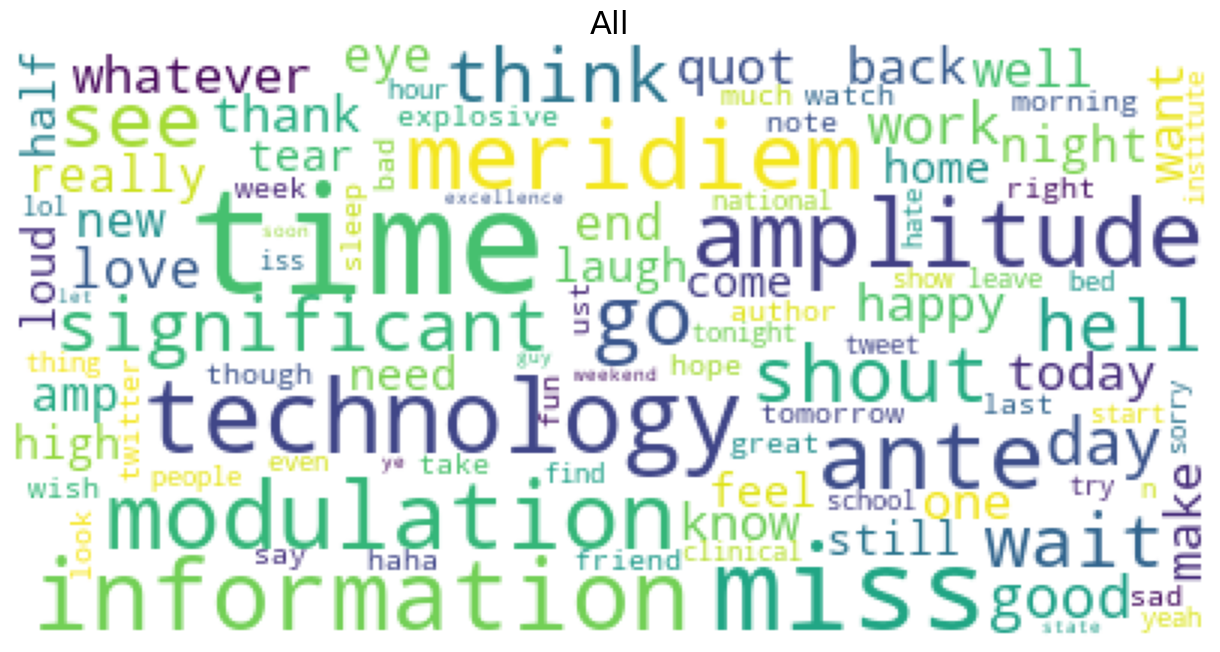

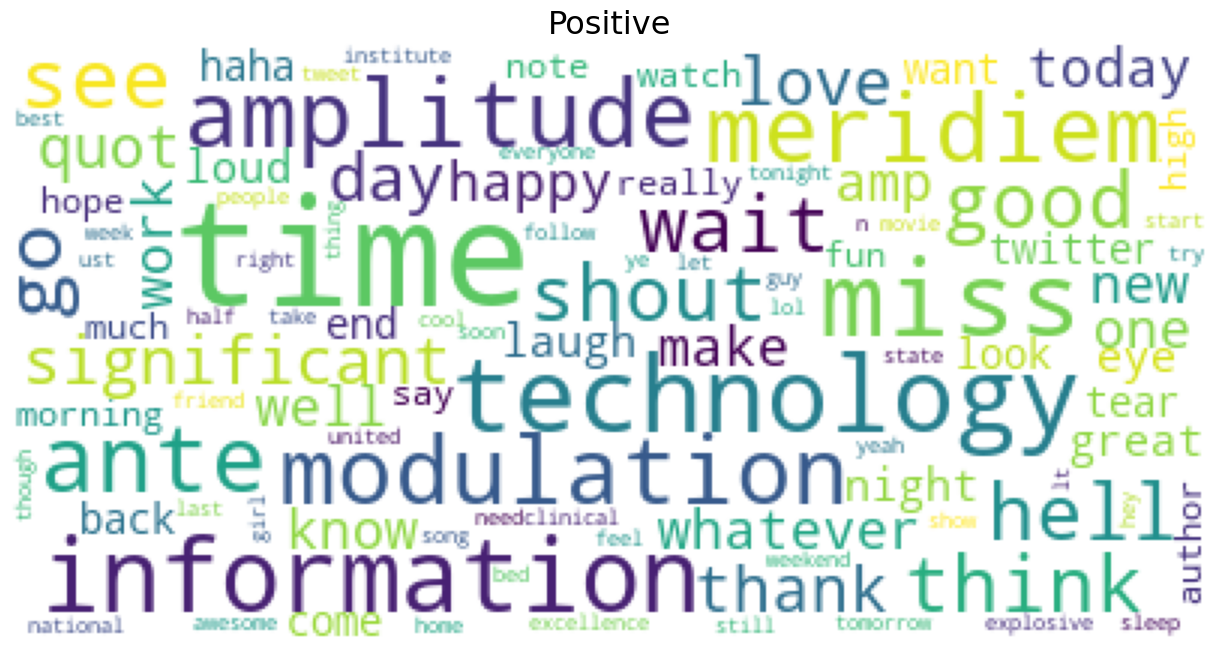

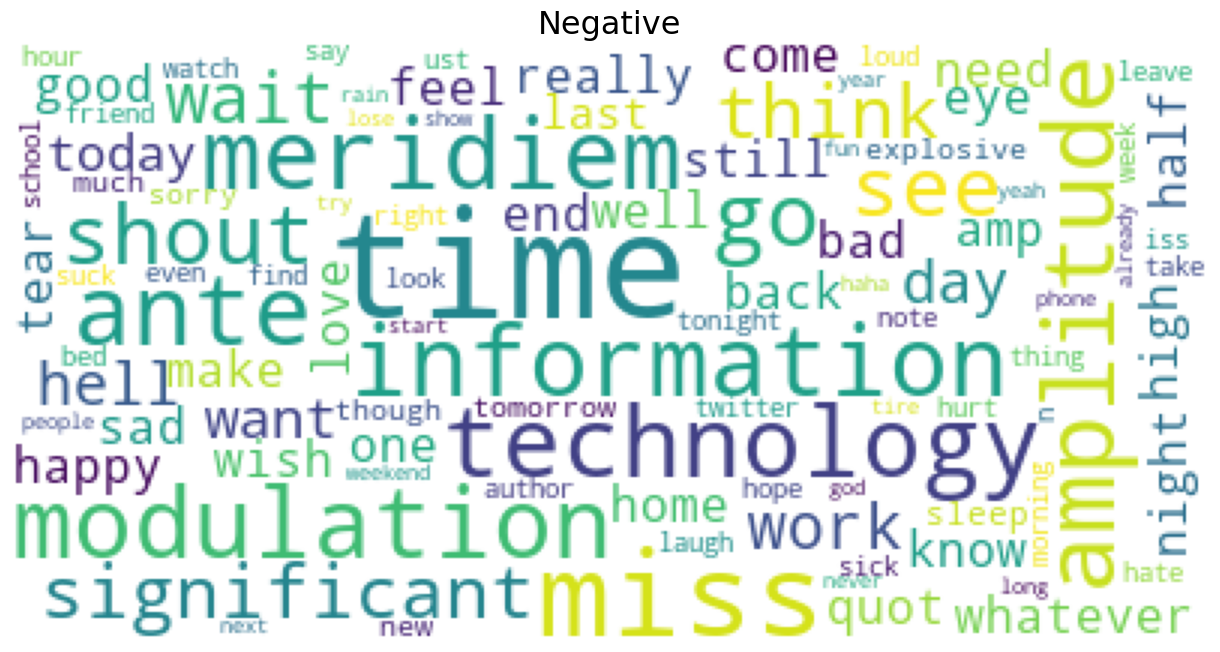

In [11]:
def show_wordcloud(series, title=None):
    # Load the DataFrame and extract the "tweet" column
    text = series.values

    # Convert the text into a single string
    text = ' '.join(text)

    # Create a WordCloud object and generate the word cloud
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(max_words=100,
                          background_color ='white',
                          stopwords = stopwords,
                          max_font_size = 50, collocations=False).generate(text)

    # Display the word cloud
    plt.figure(figsize = (12, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(title, fontsize=23)
    plt.show()


show_wordcloud(df['tweet'], "All")
print()

sentiments = ['Positive', 'Negative']
for sentiment in sentiments:
    data = df[df['target']==sentiment]['tweet']
    show_wordcloud(data, sentiment)
    print()
    print()

Defining the Tokenizer and fitting it on the training data. Here, we are tokenzing the data by spliting it up with the delimiter space ' '.


filters: Characters to filter out from the sentences to tokenize.


lower: True/False. Whether to lowerCase the sentence or not.


oov_token: Out of Vocabulary token to put in for words which aren't in the tokenizer vocab.

In [12]:
def create_tokenizer(sentences):
  tokenizer = Tokenizer(filters=" ", lower=False, oov_token="<oov>")
  tokenizer.fit_on_texts(sentences)
  return tokenizer

def max_sentence_length(lines):
  return max(len(sentence.split()) for sentence in lines)

def encode_sequences(tokenizer,sentences,max_sent_len):
  text_to_seq = tokenizer.texts_to_sequences(sentences) # encode sequences with integers
  text_pad_seq = pad_sequences(text_to_seq,maxlen=max_sent_len,padding='post') # pad sequences with 0
  return text_pad_seq

In [13]:
tokenizer = create_tokenizer(df['tweet'])
word_index = tokenizer.word_index

vocab_size = len(tokenizer.word_index) + 1

vocab_size = len(tokenizer.word_index) + 1
print("Tokenizer vocab length:", vocab_size)

max_sequence_len = max_sentence_length(df['tweet'])
print('Maximum sequence length for inputs:', max_sequence_len)

input_seq = encode_sequences(tokenizer, df['tweet'], max_sequence_len)
input_seq

Tokenizer vocab length: 82656
Maximum sequence length for inputs: 43


array([[  184,  2754,   806, ...,     0,     0,     0],
       [  723,     9,     6, ...,     0,     0,     0],
       [  235,   518,    77, ...,     0,     0,     0],
       ...,
       [   31,    61,  1641, ...,     0,     0,     0],
       [  435,   352, 82655, ...,     0,     0,     0],
       [  603,  1085,     2, ...,     0,     0,     0]])

# Importing the GloVe Embeddings

A word embedding technique that uses a word-word co-occurence statistics from a very large corpus. Individual components of the word vectors are not necessarily interpretable, however they can super efficient at getting the semantics of sentences.

You can download the GloVe embeddings from the official webpage (https://nlp.stanford.edu/projects/glove/)

In [14]:
glove_dir = 'https://nlp.stanford.edu/data/glove.twitter.27B.zip'

embedding_dict={}
with open('glove.twitter.27B.100d.txt','r', encoding='utf8') as f:
    for line in f:
        values=line.split()
        word=values[0]      # the first entry is the word
        vectors=np.asarray(values[1:],dtype='float32')       # these are the vectors representing word embeddings
        embedding_dict[word]=vectors
f.close()

print("Glove data loaded! In total:",len(embedding_dict)," words.")

Glove data loaded! In total: 1193514  words.


**This contains 100-dimensional embedding vectors for 1193514 words.**


**The dictionary embeddings_dict contains all these relations. You can check yourself the loaded vector for any given word by calling embeddings_dict[word].**

In [15]:
embedding_dict['good']

array([ 9.1552e-02,  9.3336e-02, -2.8113e-02,  3.6990e-01,  1.8956e-01,
        4.3191e-01,  1.0266e-01,  3.4092e-01, -3.8717e-01,  5.0772e-02,
       -4.8289e-01, -3.7883e-01, -5.0020e+00, -2.7927e-01, -1.4578e-01,
       -1.0818e-01,  3.9178e-01, -4.5798e-01, -5.4712e-01, -2.0868e-01,
       -3.3495e-02,  1.0765e-01, -1.7093e-01, -1.0107e-01,  1.1071e-01,
       -1.7558e-01, -3.5739e-01,  1.5897e-01,  7.9770e-02, -9.7594e-01,
       -3.9054e-01,  1.5097e-01, -5.6339e-01,  5.0047e-01,  1.7436e-01,
        6.8966e-01,  2.6879e-01, -4.7430e-01, -1.4947e-02,  2.3483e-01,
       -9.4609e-01, -5.5384e-02,  2.7673e-01,  4.1185e-01,  3.5373e-01,
        3.6709e-01, -1.4923e-01, -6.6414e-02,  2.5766e-01, -3.6882e-03,
       -6.6522e-01,  7.5965e-02, -3.0112e-01, -1.5115e-01,  3.5540e-01,
        5.9782e-01, -2.0585e-01, -4.8643e-01,  6.6179e-01, -1.3902e-01,
        2.4042e-02, -9.1297e-01, -2.1795e-01,  4.9977e-01,  4.9224e-02,
       -4.8337e-01, -5.1529e-01, -6.8428e-01, -2.4887e-01,  5.98

Let's build embedding matrix that we'll load into an embedding layer. In this case, the embedding matrix is N-by-100 matrix, where N is the total count of distinct words in the input dataframe. If the word is not found in the embeddings_index, then the corresponding column is all-zeroes.

In [16]:
embedding_dem = 100
hits = 0
misses = 0
embedding_matrix = np.zeros((vocab_size, embedding_dem))
for word, i in word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
            
print(f"Converted {hits} words ({misses} misses).")

Converted 53829 words (28826 misses).


**Note:** LSTM is good at handling the variable-length sequences; however, LSTM can not utilize the contextual information from the future tokens and it lacks the ability to extract the local contextual information. Furthermore, not all parts of the document are equally relevant but LSTM can not recognize the different relevance between each part of the document. These problems affect the text classification accuracy of LSTM. In natural language processing tasks like sentiment analysis, the meaning of a word or phrase can be influenced by both preceding and succeeding words. A Bi-RNN can effectively capture such dependencies by processing the sequence bidirectionally. That's why I'm using Bidirectional layer

In [17]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class Attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention, self).__init__()

    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(Attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

In [18]:
embedding_dim = embedding_matrix.shape[1]

In [26]:
from tensorflow.keras.initializers import Constant
from tensorflow import keras



In [27]:
## Creating model

def getModel():
    # Since we are performing sentiment analysis, we need a more efficient representation of words as compared to one_hot_encoded vectors. Hence, using embeded layer for dimensionality reduction.
    embedding_layer = Embedding(vocab_size,embedding_dim,input_length=max_sequence_len, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)

    model = Sequential([
        # Layer 1 is embedding layer
        embedding_layer,
        
        # Layer 2 is a Bidirectional LSTM layer
        # The activation of the this layer issue a vector rather than a sequence. But the next Bidirectional layer requires a three dimension input. To solve this issue, add the return_sequences=True in the layer.
        Bidirectional(LSTM(128, return_sequences=True, recurrent_regularizer= regularizers.L2(1e-5))),
        BatchNormalization(),
        
        # In layer 3, we have use attention layer. 
        # Keep return_sequences=True therefore as it receives 3D input, it's output will also be in 3D. Else it would give 2D output.
        Attention(return_sequences=True),
        
        # Layer 4 is another Bidirectional LSTM layer 
        Bidirectional(LSTM(64, dropout=0.1, return_sequences=True, use_bias=True, kernel_regularizer = regularizers.L1L2(l1=1e-5, l2=1e-4))),
        layers.Conv1D(128, 3, activation='relu'),
        layers.GlobalMaxPooling1D(),
        
        # Dense Layer
        Dense(1, activation='sigmoid')
    ],
    name="Sentiment_Model")
    return model

In [28]:
model = getModel()
model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 43, 100)           8265600   
                                                                 
 bidirectional (Bidirection  (None, 43, 256)           234496    
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 43, 256)           1024      
 Normalization)                                                  
                                                                 
 attention (Attention)       (None, 43, 256)           299       
                                                                 
 bidirectional_1 (Bidirecti  (None, 43, 128)           164352    
 onal)                                                           
                                                   

**Note:**

ReduceLROnPlateau: Reduces Learning Rate whenever the gain in performance metric specified stops improving.

EarlyStopping: Stop training when a monitored metric has stopped improving.

In [29]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [30]:
X = np.array(input_seq)

df['target'] = df['target'].replace({"Negative": 0, "Positive": 1})
y = np.array(df['target'])

X.shape

(246308, 43)

In [34]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(
    X, y,
    batch_size=256,
    epochs=10,
    validation_split=0.20,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/10
770/770 [==============================] - 342s 435ms/step - loss: 0.4743 - accuracy: 0.7759 - val_loss: 0.5003 - val_accuracy: 0.7589 - lr: 0.0010
Epoch 2/10
770/770 [==============================] - 344s 447ms/step - loss: 0.4654 - accuracy: 0.7812 - val_loss: 0.4898 - val_accuracy: 0.7658 - lr: 0.0010
Epoch 3/10
770/770 [==============================] - 356s 462ms/step - loss: 0.4569 - accuracy: 0.7872 - val_loss: 0.4922 - val_accuracy: 0.7653 - lr: 0.0010
Epoch 4/10
770/770 [==============================] - 359s 466ms/step - loss: 0.4476 - accuracy: 0.7931 - val_loss: 0.4928 - val_accuracy: 0.7654 - lr: 0.0010
Epoch 5/10
770/770 [==============================] - 359s 466ms/step - loss: 0.4376 - accuracy: 0.8002 - val_loss: 0.4994 - val_accuracy: 0.7685 - lr: 0.0010
Epoch 6/10
770/770 [==============================] - 359s 466ms/step - loss: 0.4272 - accuracy: 0.8066 - val_loss: 0.5103 - val_accuracy: 0.7629 - lr: 0.0010
Epoch 7/10
770/770 [==========================

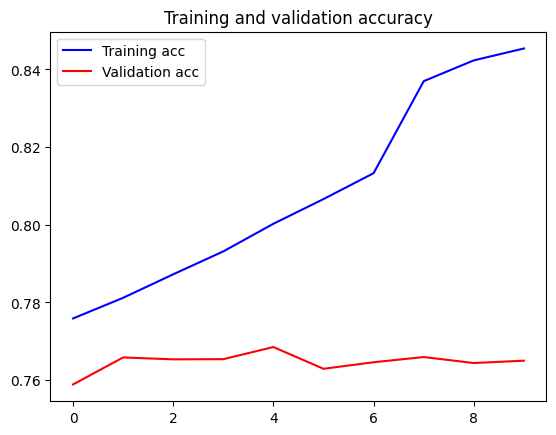

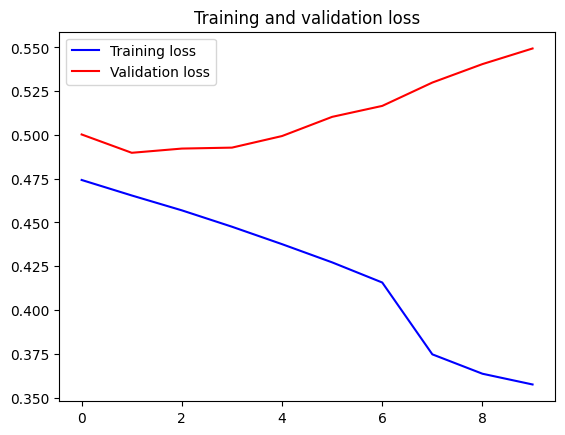

In [35]:
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

below step may take around 1 minute

In [36]:
test = cleaning(test)
X_test = test['tweet']
y_test = np.array(test['target'].replace({"Negative": 0, "Positive": 1}))

token_list = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_sequence_len, padding='post')
y_pred = model.predict(token_list, verbose=0)
y_pred = np.where(y_pred>=0.5, 1, 0)

from sklearn.metrics import confusion_matrix,accuracy_score
print("Accuracy: ")
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

Accuracy: 
0.7308
[[ 9892  3876]
 [ 3527 10205]]


In [37]:
import pickle

def save_tokenizer(tokenizer, path):
    with open(path, 'wb') as f:
        pickle.dump(tokenizer, f)

# Save tokenizer
save_tokenizer(tokenizer, 'tokenizer.pkl')
# Save model
model.save("twitter_sentiment.keras")

# **Thank You**